# 4. Standard Authentication System With Traffic
## 4.1. Import Libraries and Dependencies

In [1]:
import os
import sys  
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
warnings.filterwarnings('ignore')
matplotlib.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 14})
sys.path.insert(1, '../../src/03_user_authentification')
from user_authentification import GameAuthenticator, prepare_auth_data
from intruder_authentification import (
    IntruderAuthEvaluator, 
    evaluate_authentication_system, 
    evaluate_authentication_system_with_voting
)

## 4.2. Load and Prepare Data

In [2]:
FILENAME = "TRAFFIC_WITHOUT_HEIGHT"

In [3]:
mov_forklift_simulator = pd.read_csv('../../data/processed/users/movement_slow_stat_cleaned.csv').fillna(0)
mov_beat_saber = pd.read_csv('../../data/processed/users/movement_fast_stat_cleaned.csv').fillna(0)
traffic_forklift_simulator = pd.read_csv('../../data/processed/users/traffic_slow_stat_cleaned.csv').fillna(0)
traffic_beat_saber = pd.read_csv('../../data/processed/users/traffic_fast_stat_cleaned.csv').fillna(0)

mov_forklift_simulator = mov_forklift_simulator[mov_forklift_simulator["ID"].isin(range(30,60))]
mov_beat_saber = mov_beat_saber[mov_beat_saber["ID"].isin(range(0,30))]
traffic_forklift_simulator =traffic_forklift_simulator[traffic_forklift_simulator["ID"].isin(range(30,60))]
traffic_beat_saber = traffic_beat_saber[traffic_beat_saber["ID"].isin(range(0,30))]

In [4]:
for col in mov_forklift_simulator.columns.values:
    if "PosY" in col and "Accel" not in col and "Velocity" not in col:
        for id in range(60):
            mov_forklift_simulator.loc[mov_forklift_simulator['ID'] == id,col] = mov_forklift_simulator.loc[mov_forklift_simulator['ID'] == id,col] / np.mean(mov_forklift_simulator.loc[mov_forklift_simulator['ID'] == id,col])
            mov_beat_saber.loc[mov_beat_saber['ID'] == id,col] = mov_beat_saber.loc[mov_beat_saber['ID'] == id,col] / np.mean(mov_beat_saber.loc[mov_beat_saber['ID'] == id,col])

In [5]:
columns_to_drop = ['time_25%', 'time_50%', 'time_75%', 'time_max', 'time_mean', 'time_min', 'time_std']
mov_forklift_simulator.drop(columns=columns_to_drop, inplace=True)
mov_beat_saber.drop(columns=columns_to_drop, inplace=True)

## 4.3. Prepare Authentication Data

In [6]:
# Prepare data for authentication
authentication_data = prepare_auth_data(
    mov_forklift_simulator, 
    mov_beat_saber, 
    traffic_forklift_simulator, 
    traffic_beat_saber,
    include_traffic=True,
    n_intruders=120, 
)

In [7]:
# Look at the structure of sample users' datasets
print(f"\nSample Forklift Simulator User Data:")
sample_forklift_user = authentication_data['forklift_simulator']['user_ids'][0]
print(f"User ID: {sample_forklift_user}")
print(f"Data shape: {authentication_data['forklift_simulator']['datasets'][sample_forklift_user].shape}")
print(f"Class balance:")
print(authentication_data['forklift_simulator']['datasets'][sample_forklift_user]['is_genuine'].value_counts())


Sample Forklift Simulator User Data:
User ID: 30
Data shape: (180, 494)
Class balance:
is_genuine
0    120
1     60
Name: count, dtype: int64


In [8]:
print(f"\nSample Beat Saber User Data:")
sample_beat_saber_user = authentication_data['beat_saber']['user_ids'][0]
print(f"User ID: {sample_beat_saber_user}")
print(f"Data shape: {authentication_data['beat_saber']['datasets'][sample_beat_saber_user].shape}")
print(f"Class balance:")
print(authentication_data['beat_saber']['datasets'][sample_beat_saber_user]['is_genuine'].value_counts())


Sample Beat Saber User Data:
User ID: 0
Data shape: (180, 494)
Class balance:
is_genuine
0    120
1     60
Name: count, dtype: int64


## 4.4. Train and Compare Multiple Models

In [9]:
# Create game authenticator instance
authenticator = GameAuthenticator(authentication_data)

# Train multiple models
authenticator.train_multiple_models(test_size=0.2, use_time_intervals=False, compare_models=True, apply_smote = True, filename = FILENAME)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [10]:
# Get performance metrics
performance_metrics = authenticator.get_performance_summary()

# Show average performance by model type
model_performance = performance_metrics.groupby(['Game_Type', 'Model_Type']).mean().reset_index()
print("Average model performance across all users:")
display(model_performance[['Game_Type', 'Model_Type', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']])

Average model performance across all users:


,Game_Type,Model_Type,Accuracy,Precision,Recall,F1,AUC
0,beat_saber,AdaBoost,0.974789,0.968634,0.963889,0.965106,0.994048
1,beat_saber,DecisionTree,0.928970,0.912684,0.902778,0.904334,0.924333
2,beat_saber,GaussianNB,0.878466,0.811335,0.938889,0.860707,0.908913
3,beat_saber,GradientBoosting,0.939488,0.927526,0.913889,0.919178,0.958042
4,beat_saber,KNN,0.837671,0.728475,0.977778,0.827146,0.935030
5,beat_saber,LogisticRegression,0.959463,0.935183,0.963889,0.947430,0.987045
6,beat_saber,MLP,0.955836,0.955003,0.930556,0.939133,0.988371
7,beat_saber,RandomForest,0.974266,0.979212,0.952778,0.963853,0.996482
8,beat_saber,SVM,0.917784,0.864865,0.947222,0.898693,0.977686
9,beat_saber,XGBoost,0.962200,0.960798,0.938889,0.947938,0.985832


In [11]:
# Show which models performed best for most users
best_model_counts = {}
for game_type in ['forklift_simulator', 'beat_saber']:
    best_model_counts[game_type] = {}
    for user_id, best_model in authenticator.best_models[game_type].items():
        if best_model:
            best_model_counts[game_type][best_model] = best_model_counts[game_type].get(best_model, 0) + 1
            
print("\nBest model distribution for Forklift Simulator:")
for model, count in sorted(best_model_counts['forklift_simulator'].items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {count}")

print("\nBest model distribution for Beat Saber:")
for model, count in sorted(best_model_counts['beat_saber'].items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {count}")


Best model distribution for Forklift Simulator:
RandomForest: 21
LogisticRegression: 5
AdaBoost: 3
GradientBoosting: 1

Best model distribution for Beat Saber:
RandomForest: 18
AdaBoost: 8
MLP: 2
LogisticRegression: 2


## 4.5. Visualize Performance Metrics

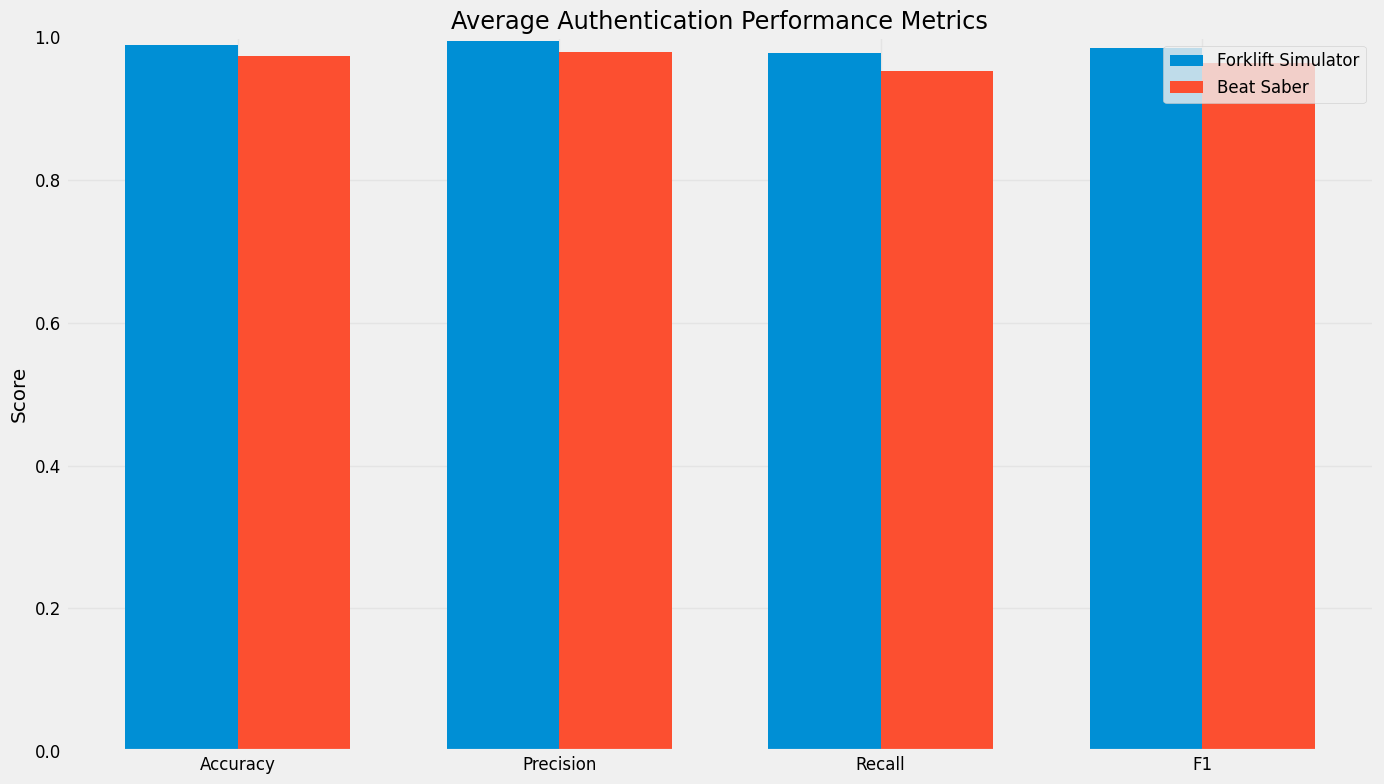

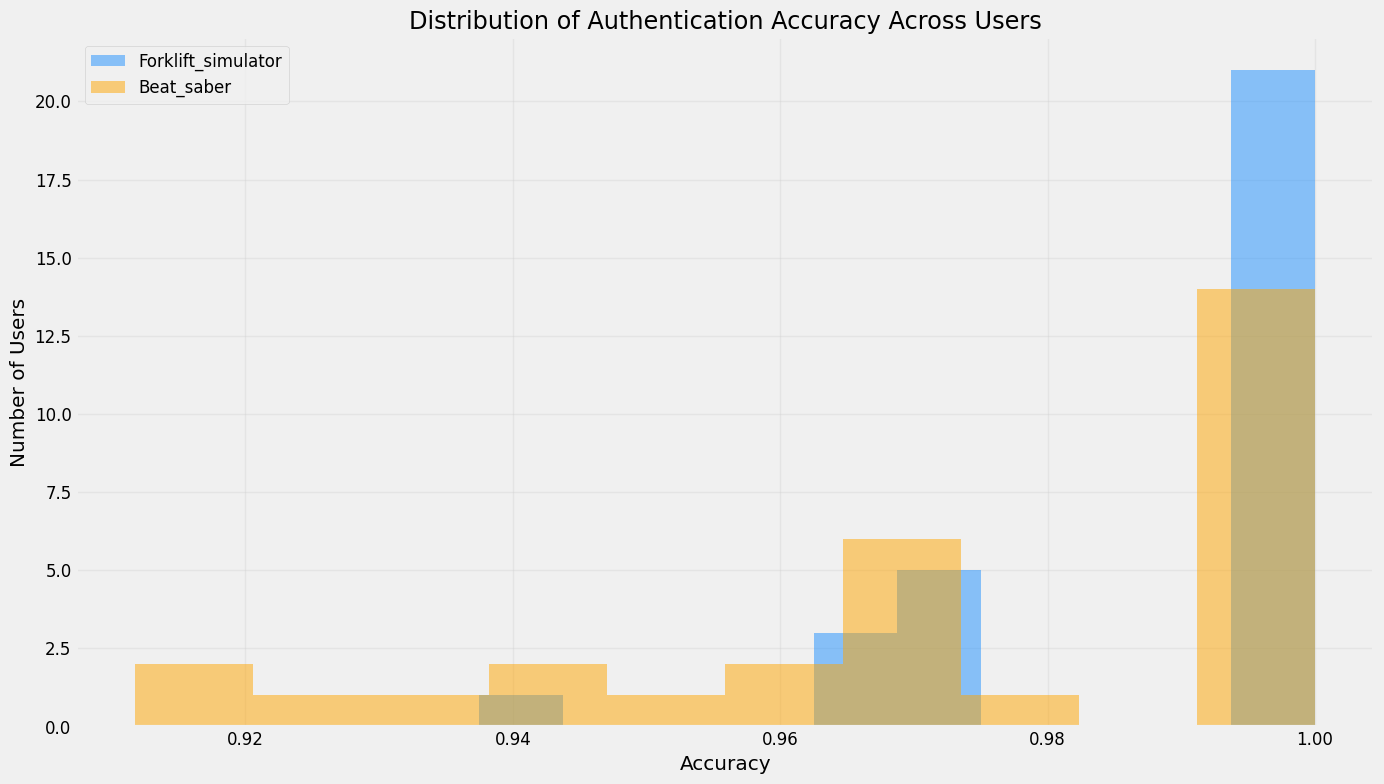

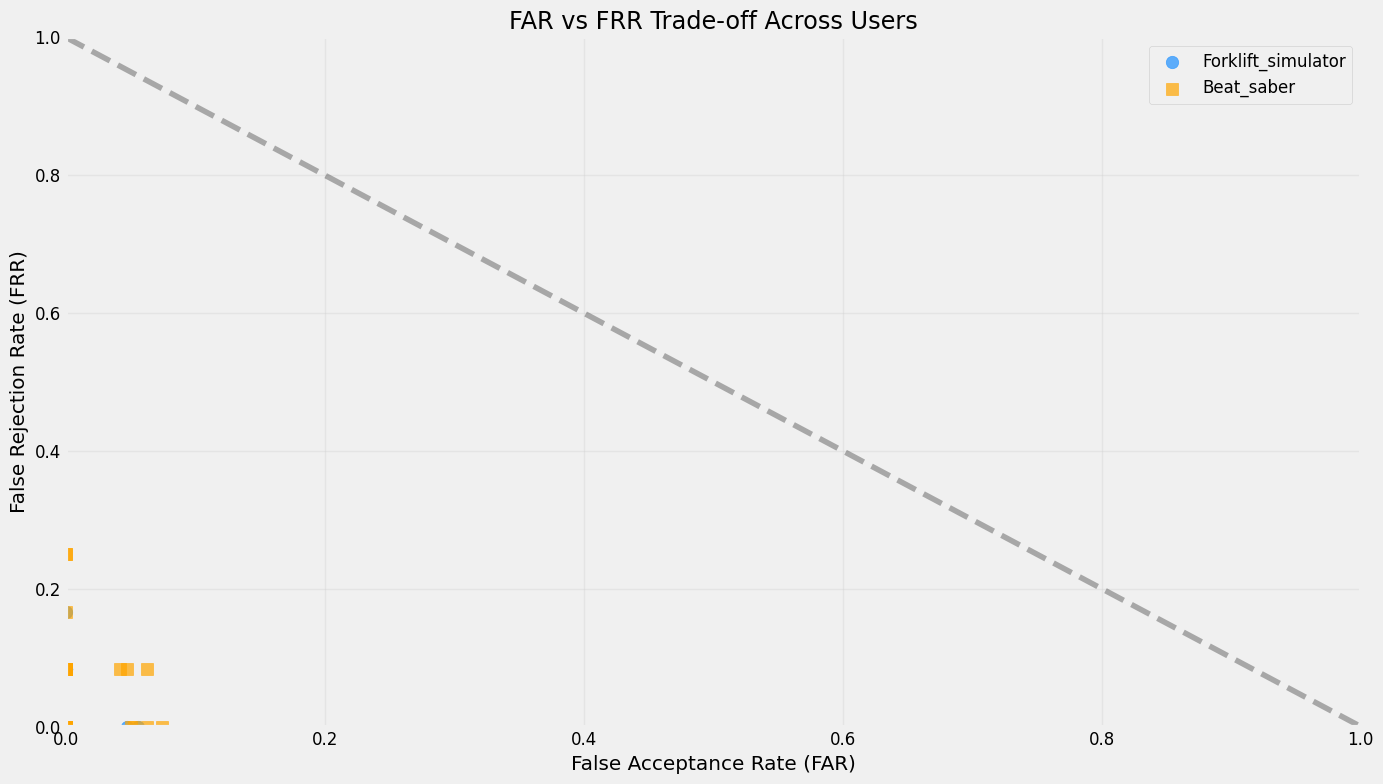

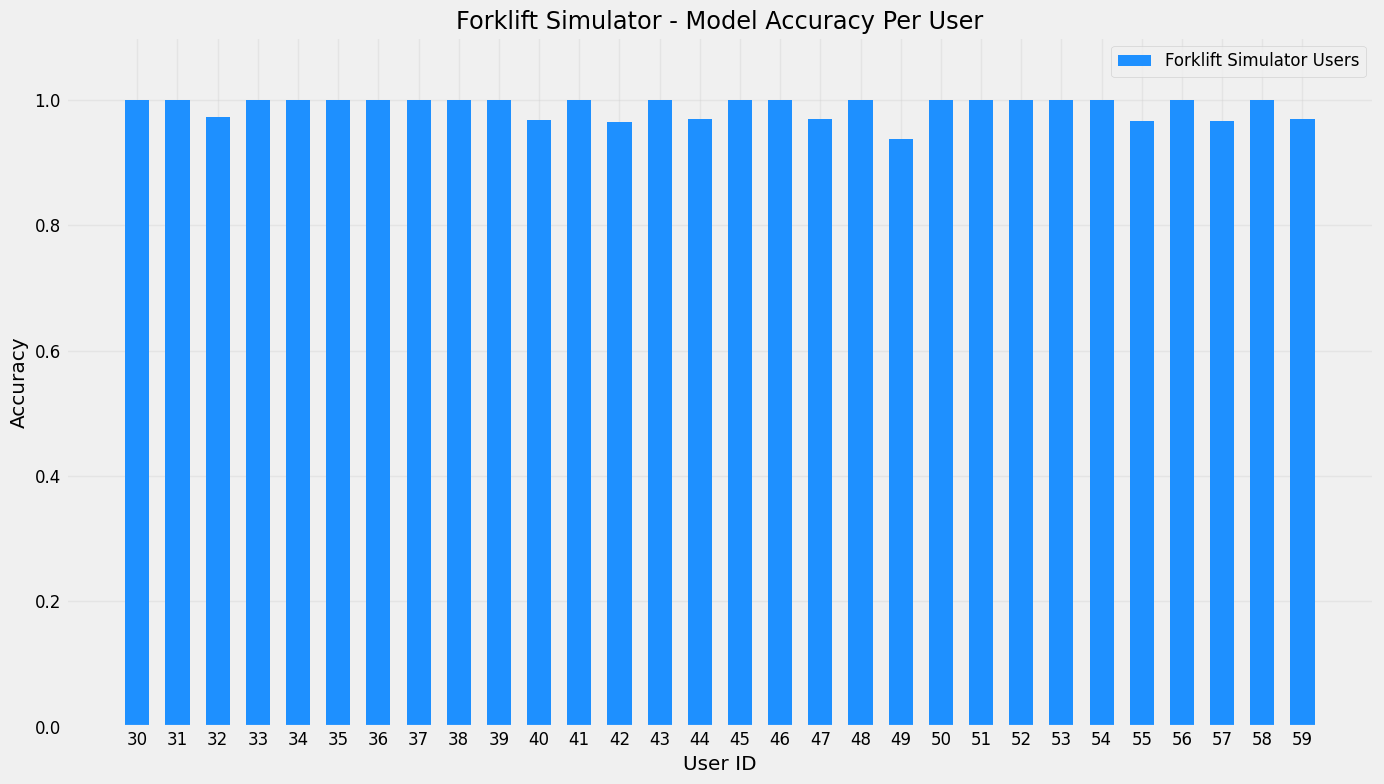

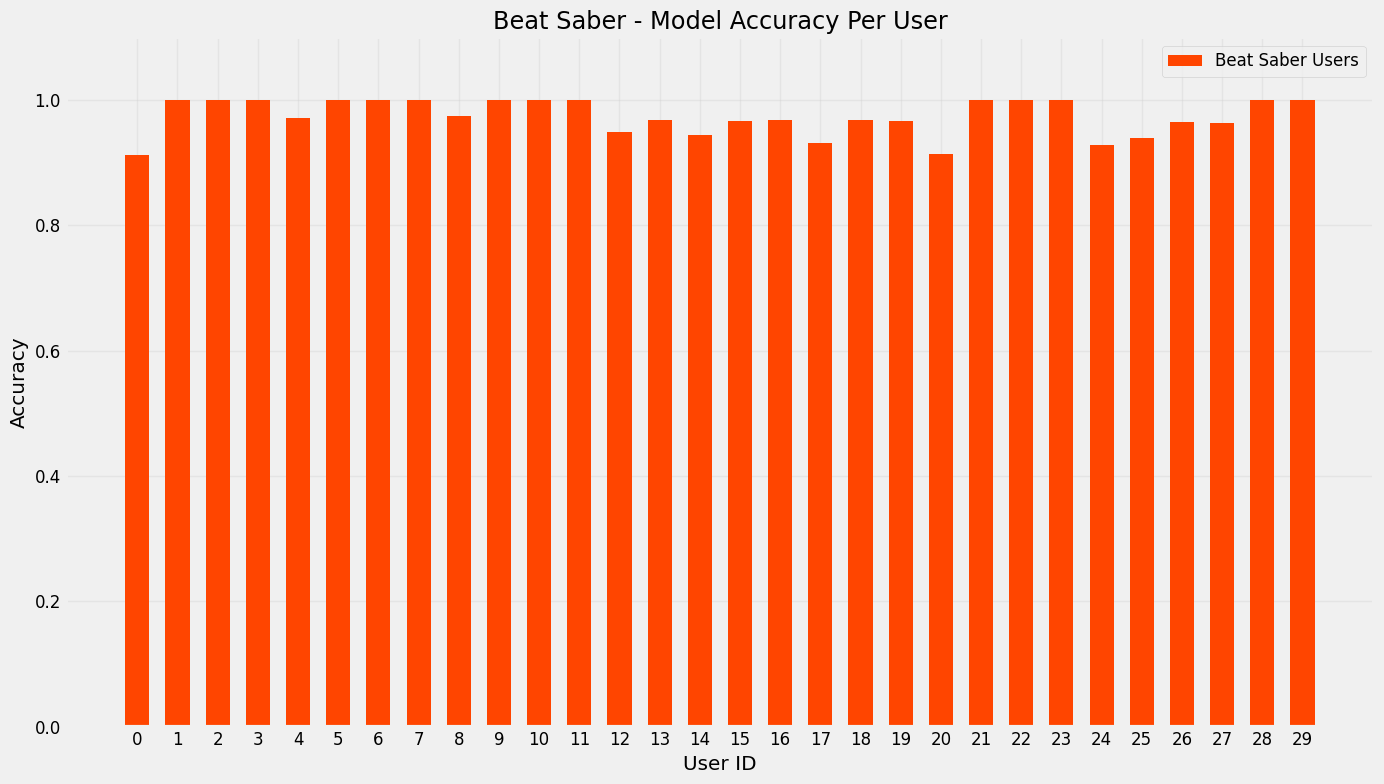

In [12]:
# Sample users for each game
sample_forklift_user = authentication_data['forklift_simulator']['user_ids'][0]
sample_beat_saber_user = authentication_data['beat_saber']['user_ids'][0]

# Visualize performance metrics using RandomForest model
authenticator.visualize_performance(
    sample_user_forklift=sample_forklift_user,
    sample_user_beat_saber=sample_beat_saber_user,
    model_name="RandomForest",
    filename = FILENAME,
)

## 4.6. Evaluate Authentication With Voting

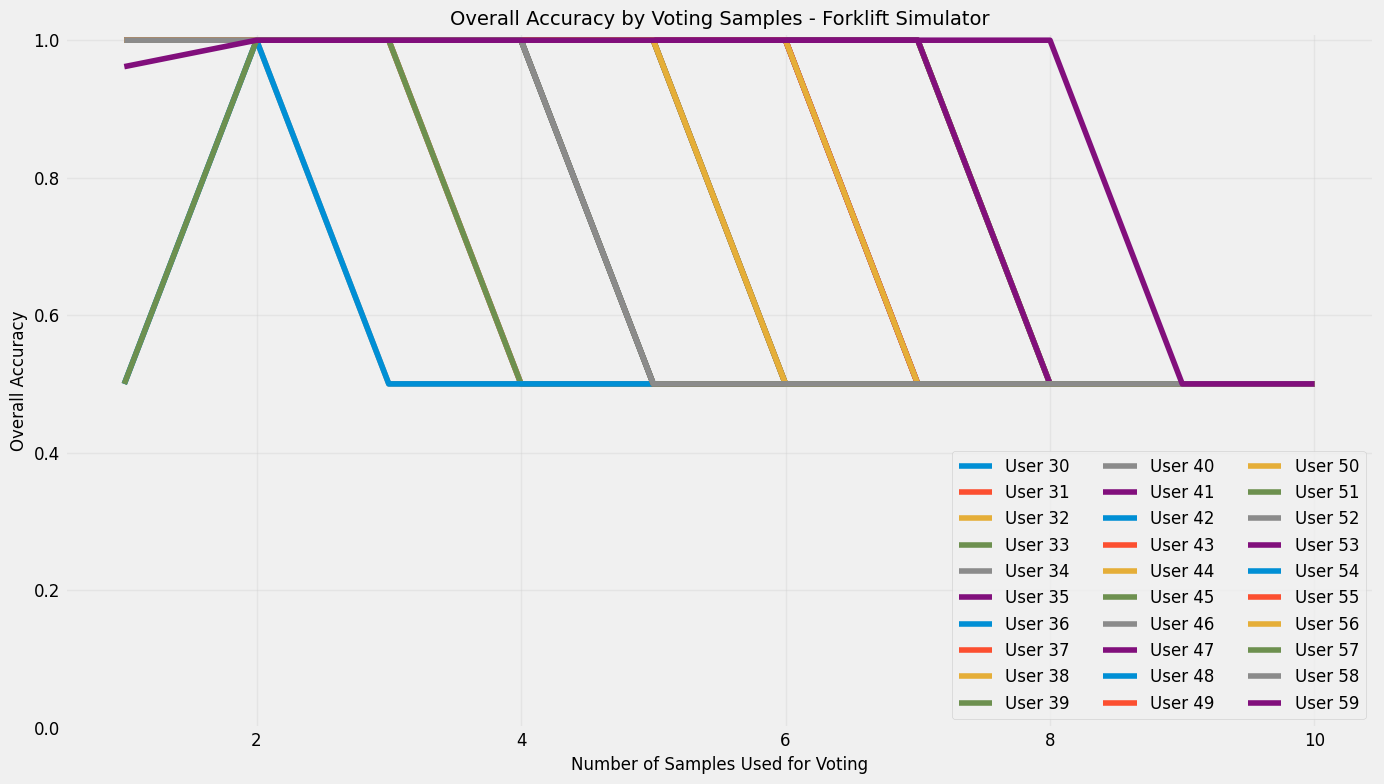

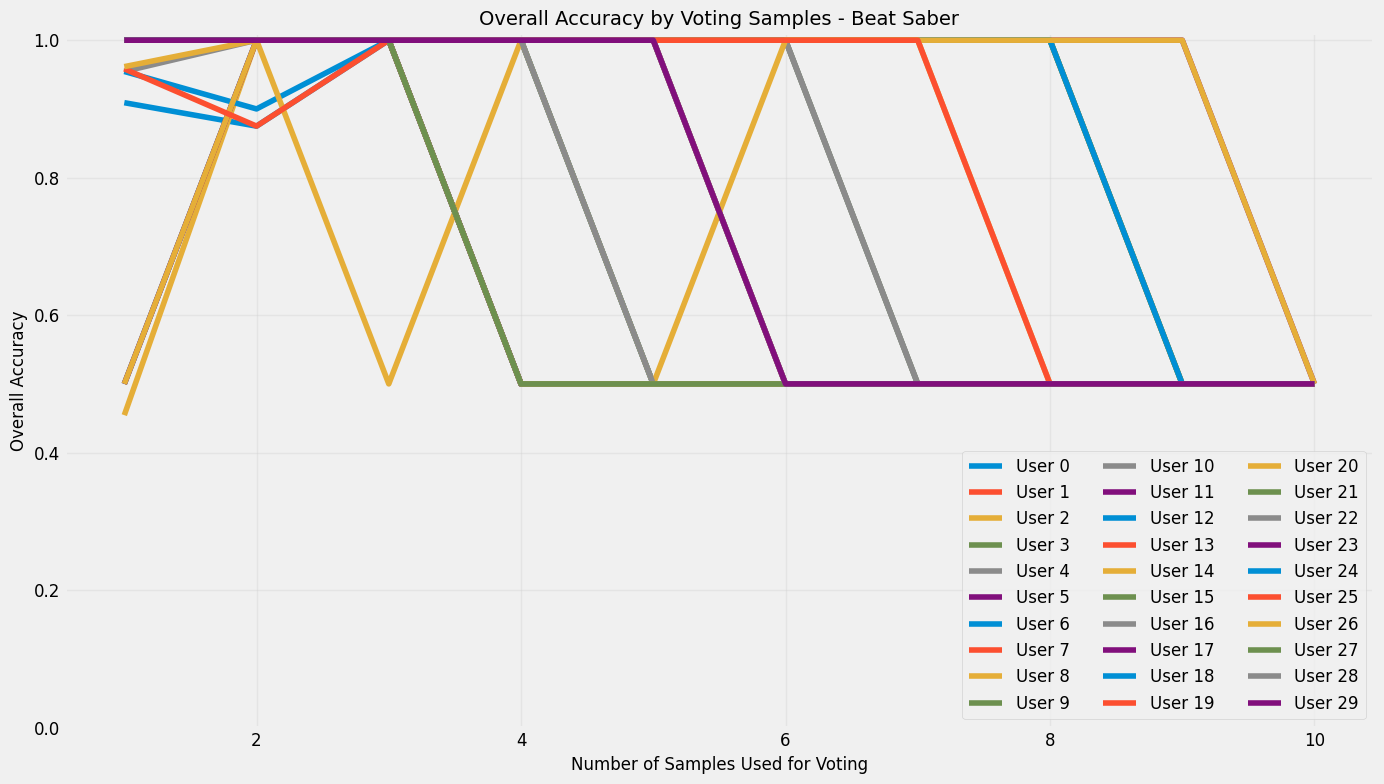

In [13]:
results = authenticator.analyze_voting_sample_effect_by_user(voting_threshold=0.5, model_name="RandomForest", filename=FILENAME)

## 4.7. Feature Importance Analysis

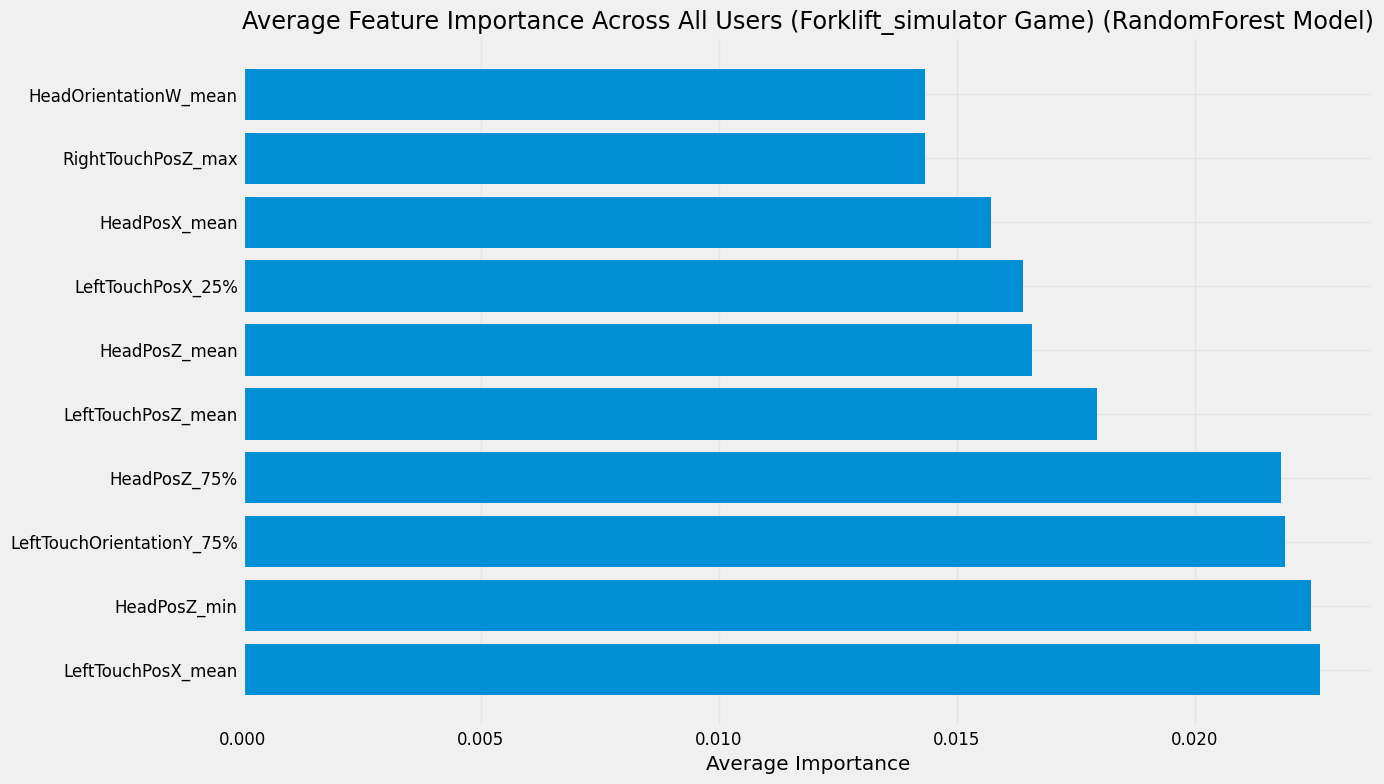

,Feature,Average_Importance
193,LeftTouchPosX_mean,0.022637
110,HeadPosZ_min,0.022450
177,LeftTouchOrientationY_75%,0.021897
107,HeadPosZ_75%,0.021823
207,LeftTouchPosZ_mean,0.017959
...,...,...
379,Velocity_LeftTouchPosX_50%,0.000044
39,Accel_LeftTouchPosZ_mean,0.000040
472,size_50%,0.000000
480,size_max,0.000000


In [14]:
authenticator.visualize_feature_importance(
    user_id=None, 
    game_type='forklift_simulator', 
    model_name='RandomForest',
    filename = FILENAME
)

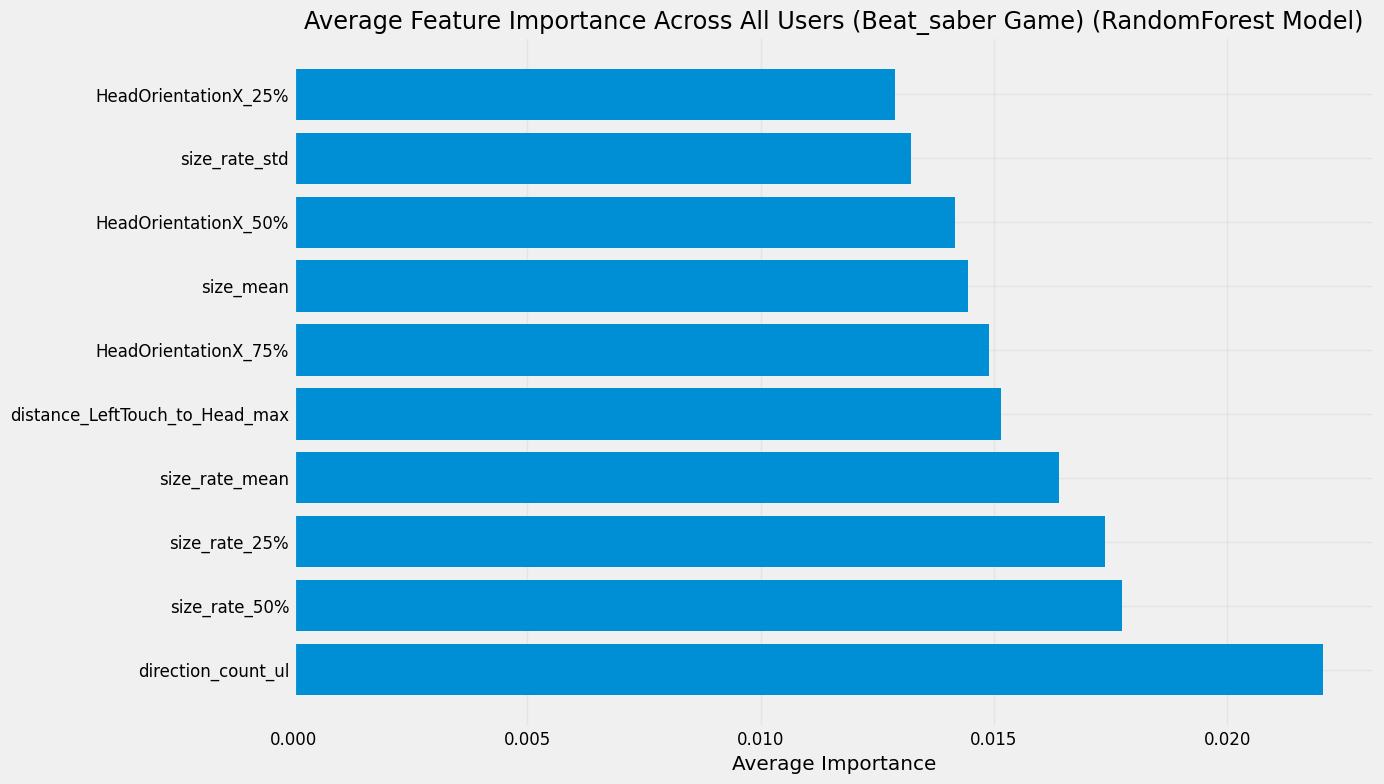

,Feature,Average_Importance
463,direction_count_ul,0.022045
483,size_rate_50%,0.017748
482,size_rate_25%,0.017387
486,size_rate_mean,0.016392
444,distance_LeftTouch_to_Head_max,0.015153
...,...,...
333,RightTouch_OrientationVelocityX_mean,0.000089
158,Head_Velocity_mean,0.000087
60,Accel_RightTouchPosZ_mean,0.000080
53,Accel_RightTouchPosY_mean,0.000073


In [15]:
authenticator.visualize_feature_importance(
    user_id=None, 
    game_type='beat_saber',  
    model_name='RandomForest',
    filename = FILENAME
)

## 4.8. Authentication Threshold Analysis

Analyze the effect of different confidence thresholds on authentication performance.

In [16]:
forklift_threshold_results = authenticator.threshold_analysis(
    user_id=None, 
    game_type='forklift_simulator', 
    model_name='RandomForest',
    filename = FILENAME,
)


FORKLIFT SIMULATOR THRESHOLD ANALYSIS


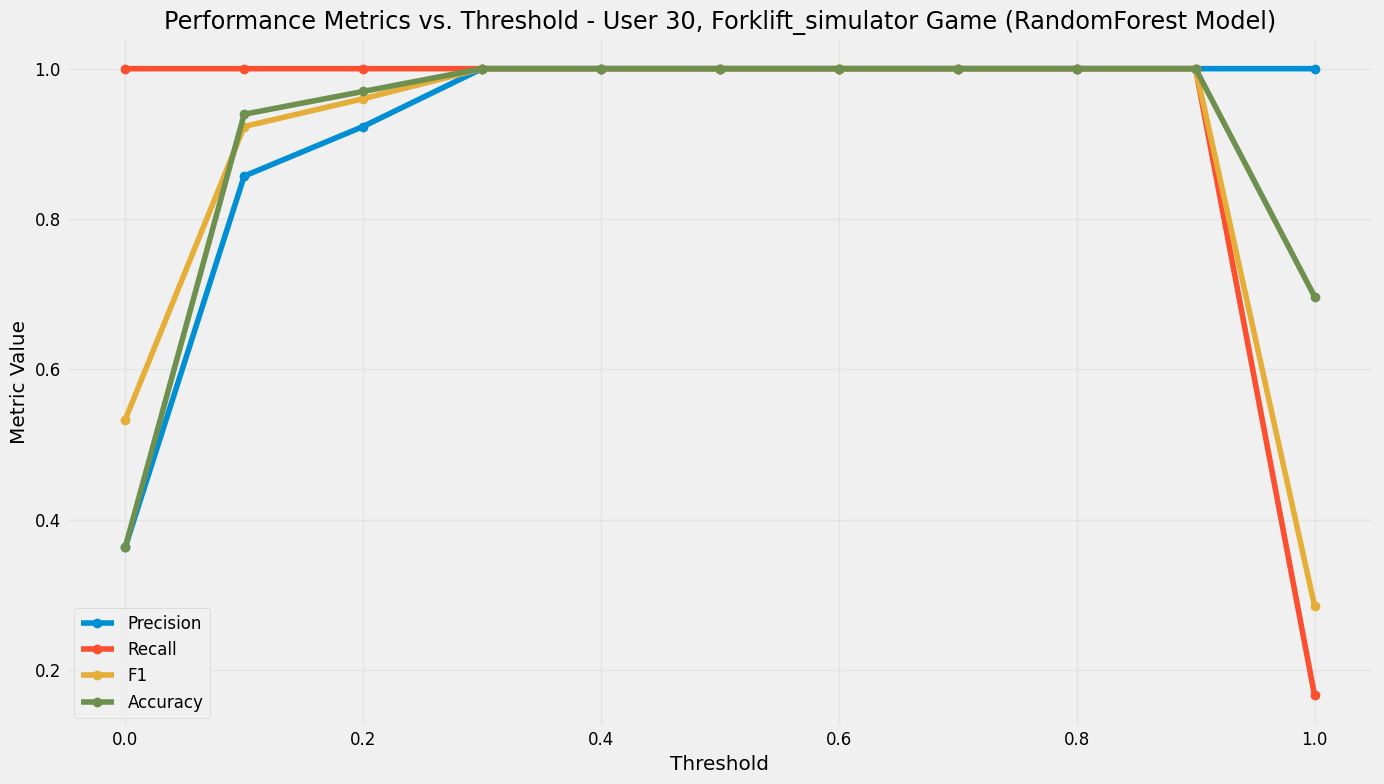

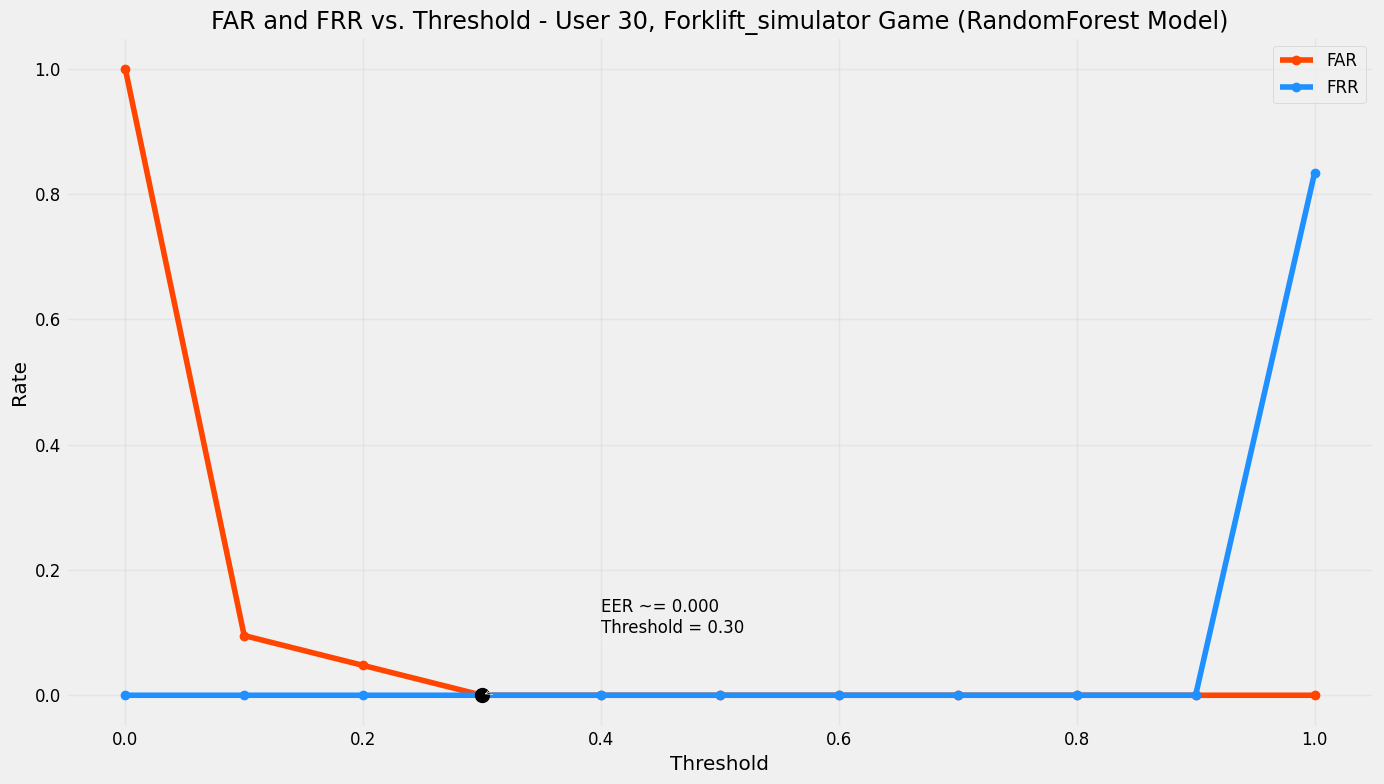

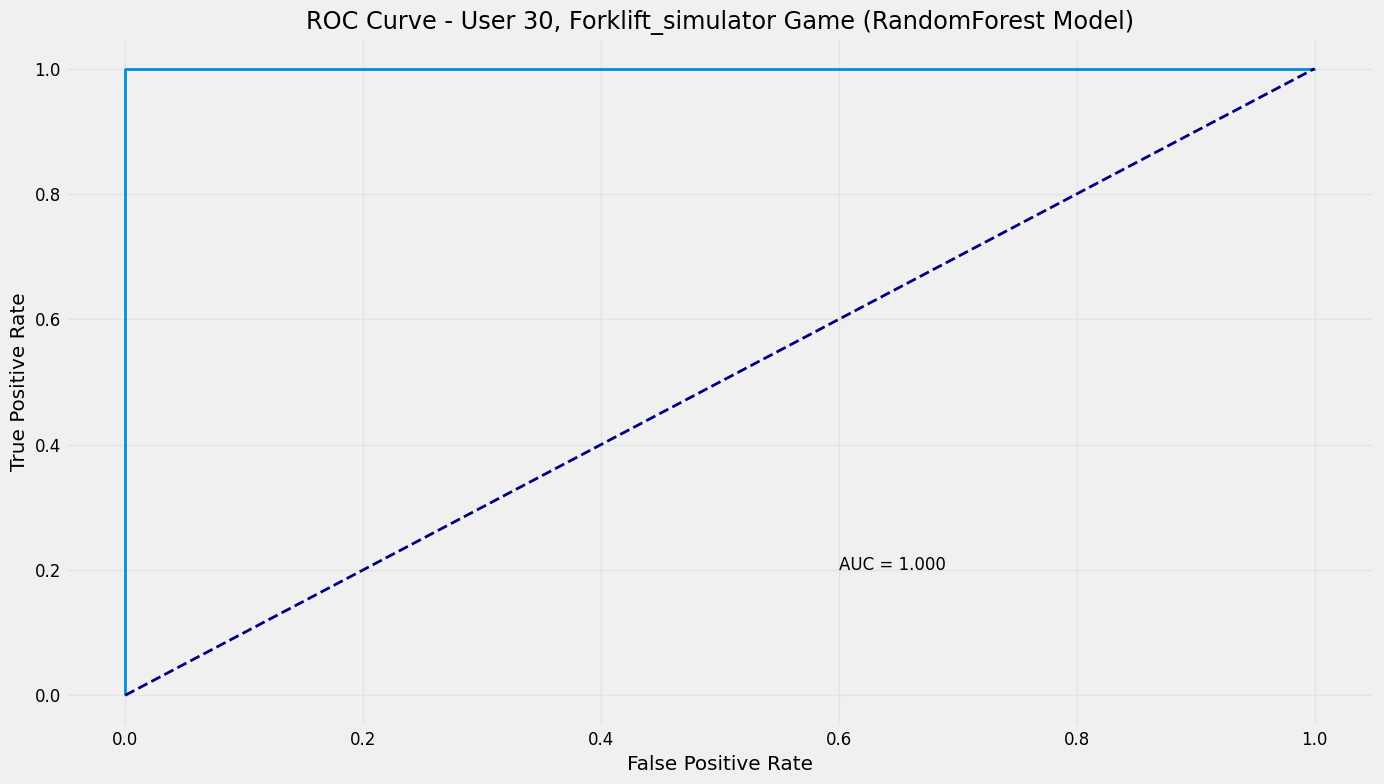

In [17]:
# Analyze authentication thresholds for sample users from each game
sample_forklift_user = authentication_data['forklift_simulator']['user_ids'][0]
print("\nFORKLIFT SIMULATOR THRESHOLD ANALYSIS")
print("====================================")
forklift_threshold_results = authenticator.threshold_analysis(
    user_id=sample_forklift_user, 
    game_type='forklift_simulator', 
    model_name='RandomForest',
    filename = FILENAME,
)


BEAT SABER THRESHOLD ANALYSIS


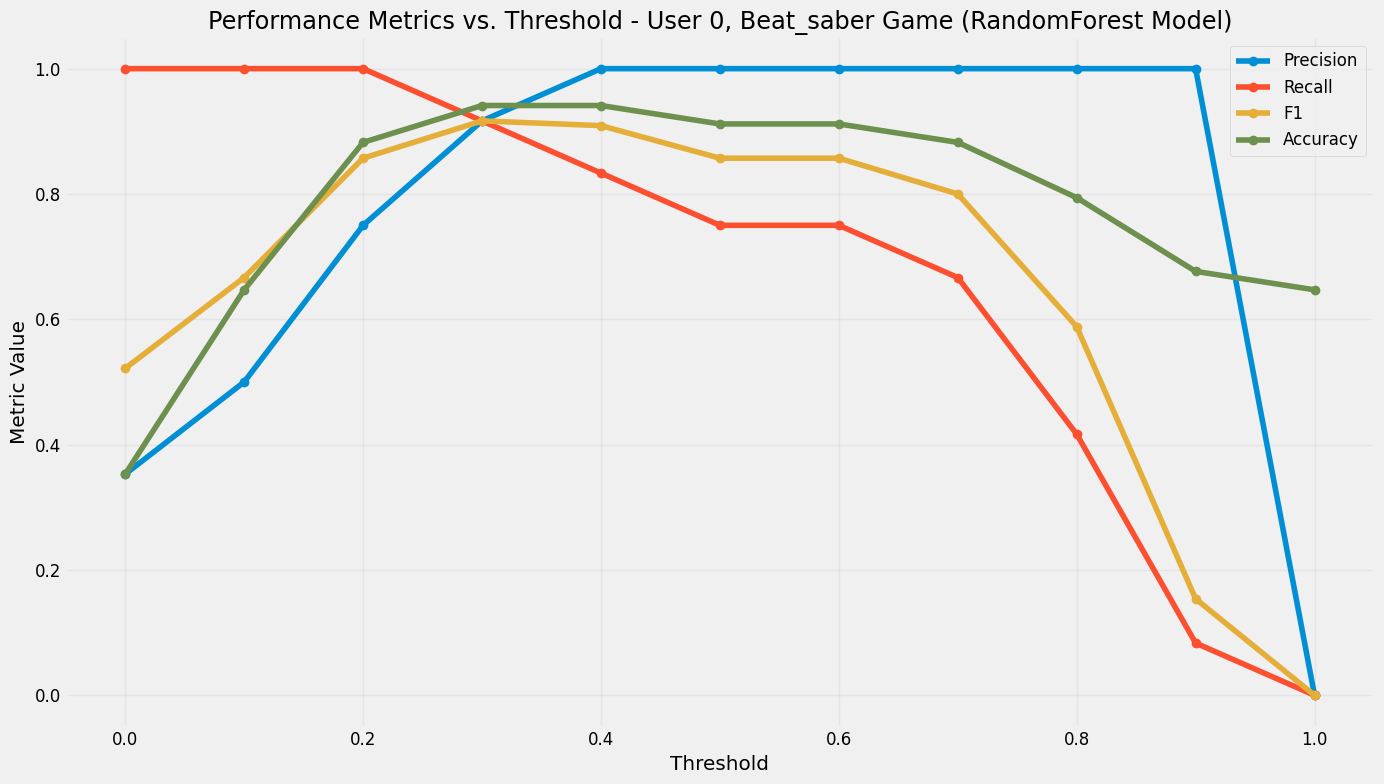

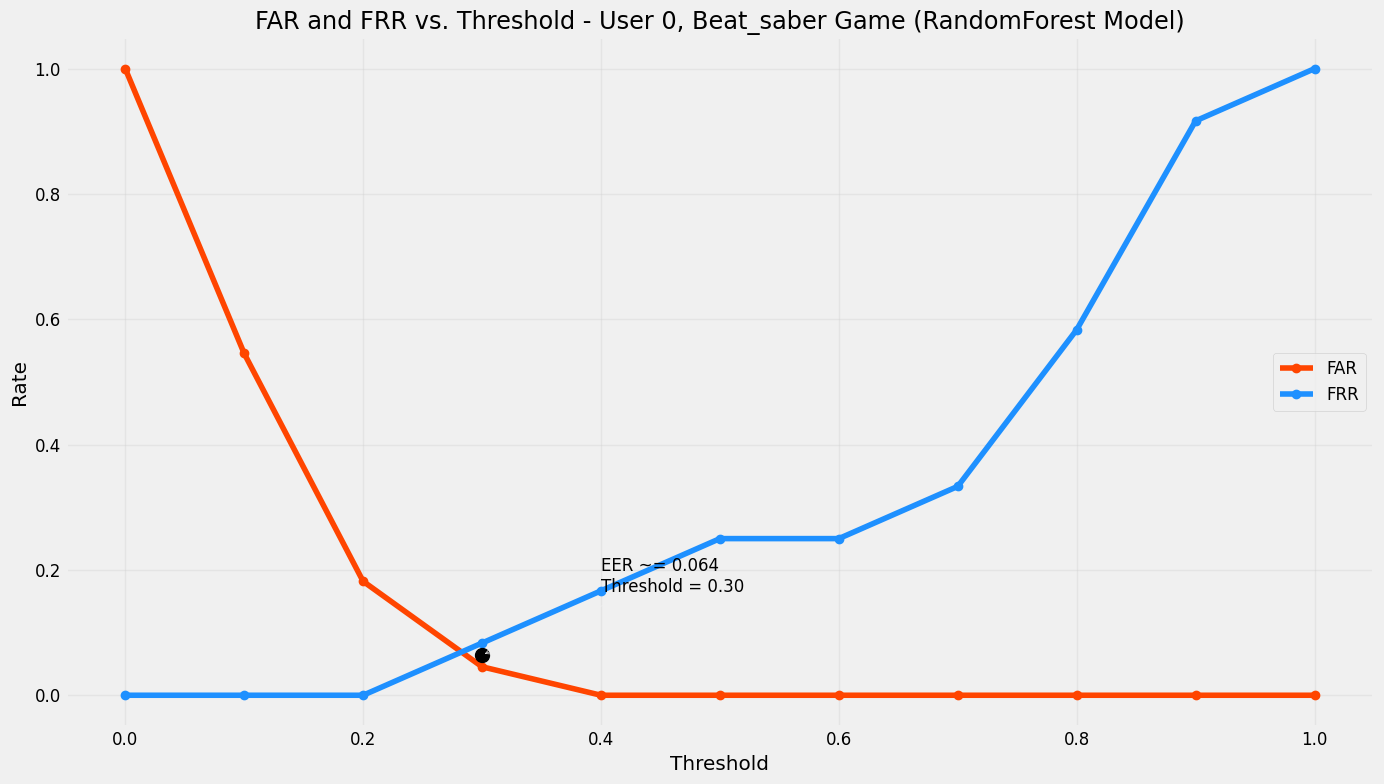

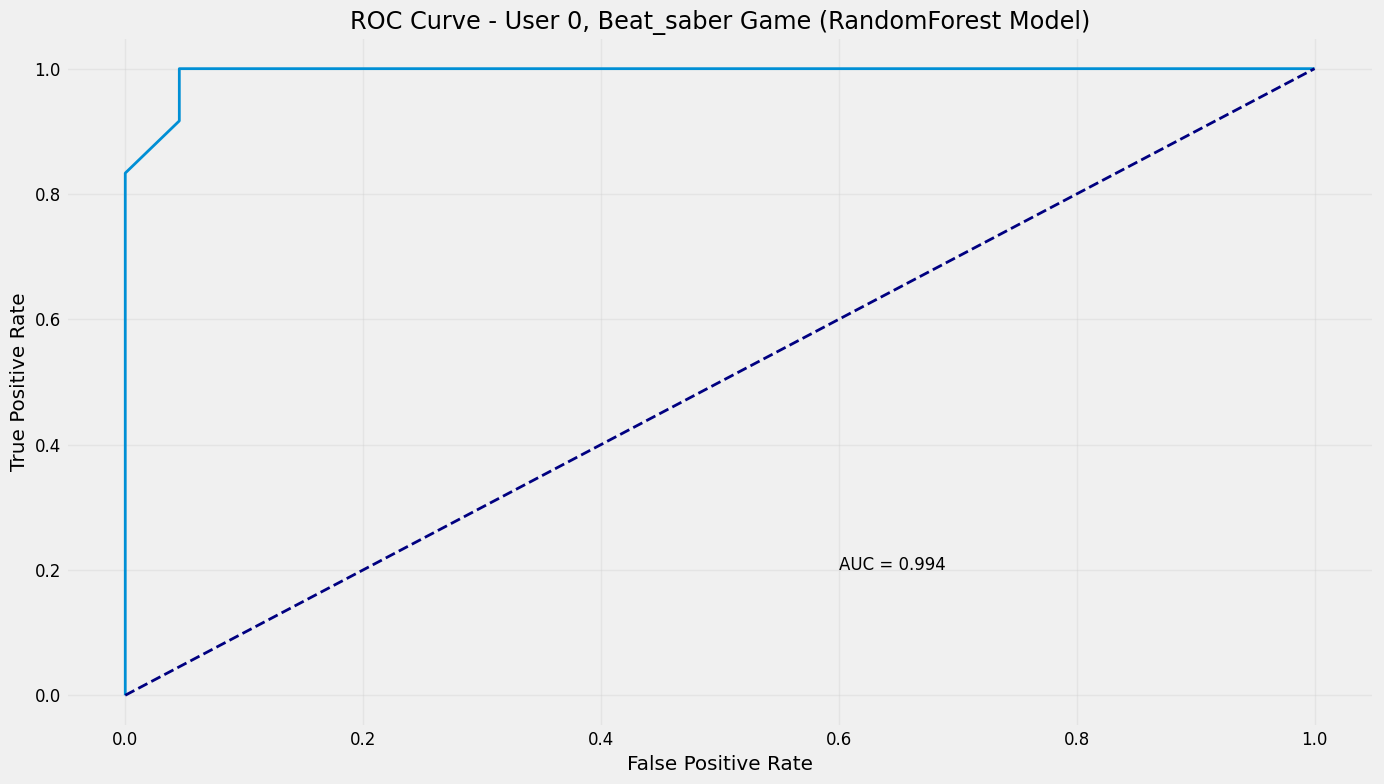

In [18]:
sample_beat_saber_user = authentication_data['beat_saber']['user_ids'][0]
print("\nBEAT SABER THRESHOLD ANALYSIS")
print("============================")
beat_saber_threshold_results = authenticator.threshold_analysis(
    user_id=sample_beat_saber_user, 
    game_type='beat_saber', 
    model_name='RandomForest',
    filename = FILENAME
)